In [162]:
# Force keras to use the CPU becuase it's actually faster for this size network
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd

from numpy import cos, sin, pi
import matplotlib.pyplot as plt
import scipy.integrate as integrate

%matplotlib inline
import matplotlib.animation as animation

from IPython.display import HTML

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.constraints import max_norm

import random

from pendulum_class import Pendulum

In [86]:
bot = Pendulum()

rad = pi/180

def controller(q, t=0):
    if (q[0] < 140 * rad) or (q[0] > 220 * rad):
        return q[1]*4
    else:
    # balancing
    # LQR: K values from MATLAB
        k1 = 140.560
        k2 = 60.162
        u = -(k1 * (q[0] - pi) + k2 * q[1])
    return u
    
bot.control = controller

theta = .1
th_dot = .1

# initial state
init_state = np.array([theta, th_dot])
dt = 0.1
time = np.arange(0.0, 5, dt)

# integrate the ODE using scipy.integrate.
y = integrate.odeint(bot.derivs, init_state, time)


u = np.zeros(len(time))

for t in range(len(time)):
    u[t] = bot.control(y[t,:]) 

        

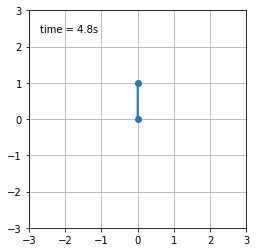

In [3]:
ani = bot.animate(time, y)
HTML(ani.to_jshtml())

In [32]:
# LSTM
with tf.variable_scope('pi/simple_pol/'):
    lstm_model = Sequential()
    lstm_model.add(LSTM(12, input_shape =(2,1)))
    lstm_model.add(Dense(1))

    #model.add(Dense(2))
    
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
# Train LSTM

lstm_history = lstm_model.fit(y.reshape(50,2,1), u, epochs=500, verbose=0)
plt.plot(lstm_history.history['loss'])
plt.title('lstm model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [90]:
# This is a closure that returns our NN controller
def make_controller(model):
    def nn_controller(q, t=0):
        
        qc = q.copy()
        qc[0] = q[0] % (2*pi)
        
        if (qc[0] < 140 * rad) or (qc[0] > 220 * rad):
             return model.predict(qc.reshape((1,2,1)))
        else:
            # balancing
            # LQR: K values from MATLAB
            k1 = 140.560
            k2 = 60.162
            u = -(k1 * (qc[0] - pi) + k2 * qc[1])
        return u       
        
    return nn_controller

In [88]:
#bot.control = make_controller(lstm_model)

# integrate the ODE using scipy.integrate.
# Fill in our u after the fact..

num_trials = 20


y_lstm = np.zeros((len(time), num_trials, num_trials, 2))
u_lstm = np.zeros((len(time), num_trials, num_trials, 1))

for i in range(num_trials):
    for j in range(num_trials):
        init_state = [2*pi*i/(num_trials) - pi, 2*pi*j/(num_trials) - pi]
        y_lstm[:,i,j,:] = integrate.odeint(bot.derivs, init_state, time)

        # TODO figure out how to just return u the first time
        for t in range(len(time)):
            u_lstm[t,i,j] = bot.control(y_lstm[t,i,j,:]) 

In [89]:
ani = bot.animate(time, y_lstm[:,10,0,:])
HTML(ani.to_jshtml())

In [174]:
# make list of trajectories that are actually balanced
# We stop the trajectory when it gets to within delta of [pi, 0], and then index it backwards in time
# So that t = 0 is when all trajectories are at the same point. t=1 is one step backwards etc. 

traj_list = []

for i in range(num_trials):
    for j in range(num_trials):
        # check if solution is within epsilon ball of [pi,0] , which is our target
        delta = .001
        if  (-delta + pi) < y_lstm[-1,i,j,0]  < (delta + pi)   and   -delta < y_lstm[-1,i,j,1]  < delta:
            #print("%d %d gives %f" % (i, j ,y_lstm[-1,i,j,0]))
            
            for t in range(0,len(y_lstm[:,i,j,0])):
                if (-delta + pi) < y_lstm[t,i,j,0]  < (delta + pi)   and   -delta < y_lstm[t,i,j,1]  < delta:
                    traj_list.append(np.flip(y_lstm[0:t,i,j,:], axis=0))
                    break
                

In [221]:
# Plot all the trajectories

%matplotlib
fig, ax = plt.subplots()
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.set_aspect('equal')
ax.grid(True, which='both')


for traj in traj_list:
    plt.plot(traj[:,0], traj[:,1],'->')

Using matplotlib backend: MacOSX


In [213]:
# Calculate thefractional dimension at each time step (or something like that anyway)
# Metho

# just calculating the length of the shortest trajectory
min_t = min([x.shape[0] for x in traj_list]) 

NR_list = []
r_delta = .01
num_point_trials = 1

for i in range(min_t):
    points = [traj[i,:] for traj in traj_list]
    NR_list.append([])
    
    
    for j in range(num_point_trials):
        tmp_list = []
        r = delta**2 # length of the ball around our point. delta from above, need to start somewhere
        N = 0
        point0 = points[random.randint(0,len(traj_list) - 1)]

        while(N < len(traj_list)):
            N = 0 # the number of points enclosed in our ball
            for point in points:
                if sum((point0 - point)**2) <= r: 
                    N+=1

            NR_list[i].append((r,N))
            r += r_delta
  

In [213]:
# Calculate thefractional dimension at each time step (or something like that anyway)

# just calculating the length of the shortest trajectory
min_t = min([x.shape[0] for x in traj_list]) 

NR_list = []
r_delta = .01
num_point_trials = 1

for i in range(min_t):
    points = [traj[i,:] for traj in traj_list]
    NR_list.append([])
    
    
    for j in range(num_point_trials):
        tmp_list = []
        r = delta**2 # length of the ball around our point. delta from above, need to start somewhere
        N = 0
        point0 = points[random.randint(0,len(traj_list) - 1)]

        while(N < len(traj_list)):
            N = 0 # the number of points enclosed in our ball
            for point in points:
                if sum((point0 - point)**2) <= r: 
                    N+=1

            NR_list[i].append((r,N))
            r += r_delta  

In [17]:
# Save to matlab. useful for plotting lots of trajectories, which matplotlib chokes on
import scipy.io as sio
sio.savemat('../matlab_lstm/pend1000.mat', {'data_overfit': y_lstm} )
